In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
import warnings
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
warnings.filterwarnings('ignore')

con = sqlite3.connect('./final.sqlite') 
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews""", con) 


In [2]:
fil_data=filtered_data.sample(n=60000)

In [3]:
fil_data=fil_data.sort_values(['Time'],axis=0)

In [4]:
data=fil_data

In [5]:
train=data[:42000]
cv=data[42001:48000]
test=data[48000:]
train.to_csv('train',sep=',',index=False)
cv.to_csv('cv',sep=',',index=False)
test.to_csv('test',sep=',',index=False)

In [6]:
train_x=train['CleanedText']
cv_x=cv['CleanedText']
test_x=test['CleanedText']

train_y=train['Score']
cvy=cv['Score']
test_y=test['Score']

In [72]:
# Function for KNN brute force with simple cross validation.
def KNN_brute(X_train,X_CV,Y_train,y_cv):
    cv_scores = []
    max_k=0;max_roc_auc=-1
    k_list=[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
    for i in k_list[-16:]:
        knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
        knn.fit(X_train,Y_train)
        pred = knn.predict(X_CV)
        # evaluate CV roc_auc score
        roc_auc=(roc_auc_score(y_cv,pred))
        cv_scores.append(roc_auc)
        if(max_roc_auc<roc_auc):
            max_roc_auc=roc_auc
            max_k=i
    print(f"\nThe 'K' value {max_k} with highest roc_auc Score is {roc_auc}" )
    sns.set_style("darkgrid")
    plt.plot(k_list,cv_scores)
    plt.title(r'roc_auc v/s K-Value')
    plt.xlabel(r"K-Values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()


In [8]:
# Function for KNN with KD-Tree with simple cross validation.
from sklearn.decomposition import TruncatedSVD
def KNN_KD_Tree(X_train,y_train,X_CV,y_cv):
    cv_scores = []   
    svd = TruncatedSVD()
    X_tr = svd.fit_transform(X_train)
    X_cv = svd.fit_transform(X_CV)
    max_k=0;max_roc_auc=-1
    k_list=[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29]
    for i in k_list[-16:]:
        knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree')
        knn.fit(X_train,y_train)
        pred = knn.predict(X_CV)
        # evaluate CV roc_auc score
        roc_auc=(roc_auc_score(y_cv,pred)*100)
        cv_scores.append(roc_auc)
        if(max_roc_auc<roc_auc):
            max_roc_auc=roc_auc
            max_k=i
    print(f"\nThe 'K' value {max_k} with highest roc_auc Score is {roc_auc}" ) 
    sns.set_style("darkgrid")
    plt.plot(k_list,cv_scores)
    plt.title(r'roc_auc v/s K-Value')
    plt.xlabel(r"K-Values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()


In [9]:
#Finding best K value using k-fold cv


In [10]:
#test data 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
def testing(train,y_train,test,y_test,k_best):
    knn = KNeighborsClassifier(n_neighbors=k_best,algorithm='brute')
    knn.fit(train,y_train)
    pred = knn.predict(test)
    #print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, pred)*100))
    print("\nROC_AUC Score on test data:%0.3f%%"%(roc_auc_score(y_test,pred)*100))
    #y=np.array(test*100_y)
    #pre=np.array(pred)
    precision=precision_score(test_y,pred, average='micro')*float(100)  
    print("\nPrecision measure is ",precision)
    rec=recall_score(test_y, pred, average='micro')*float(100)
    print("\nRecall measure is ",rec)
    print("\nConfusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
    confusionMatrix=confusion_matrix(y_test,pred)
    df_cm = pd.DataFrame(confusionMatrix, range(2),range(2))
    plt.figure(figsize = (7,5))
    plt.ylabel("True Label")
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix")
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 12},fmt="d")# font size

# Bag of Word Vectorization

In [11]:
bow = CountVectorizer()
Train_bow = bow.fit_transform(train_x)
cv_bow=bow.transform(cv_x)
test_bow = bow.transform(test_x)
#Normalize Data
Train_bow=preprocessing.normalize(Train_bow)
print("Train Data Size: ",Train_bow.shape)
cv_bow= preprocessing.normalize(cv_bow)
print("CV Data Size: ",cv_bow.shape)
test_bow=preprocessing.normalize(test_bow)
print("Test Data Size: ",test_bow.shape)

Train Data Size:  (42000, 25241)
CV Data Size:  (5999, 25241)
Test Data Size:  (12000, 25241)


In [12]:
from scipy import sparse

sparse.save_npz("train_bow.npz",Train_bow)
sparse.save_npz("cv_bow.npz",cv_bow)
sparse.save_npz("test_bow.npz",test_bow)
#your_matrix_back = sparse.load_npz("yourmatrix.npz")#to load our sparse matrix from npz files


The 'K' value 1 with highest roc_auc Score is 0.5349664817102457


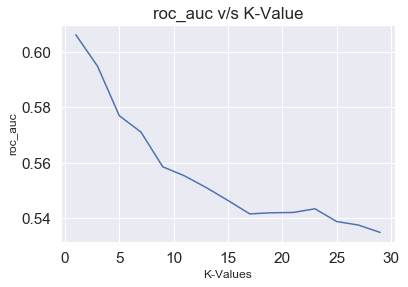

In [73]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
KNN_brute(Train_bow,cv_bow,train_y,cvy)


The 'K' value 1 with highest roc_auc Score is 53.496648171024574


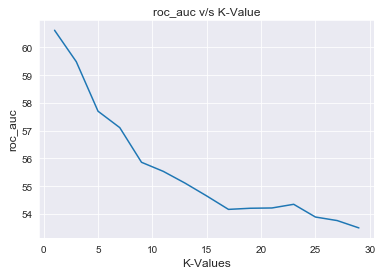

In [14]:
KNN_KD_Tree(Train_bow,train_y,cv_bow,cvy)


ROC_AUC Score on test data:61.485%

Precision measure is  80.64166666666667

Recall measure is  80.64166666666667

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



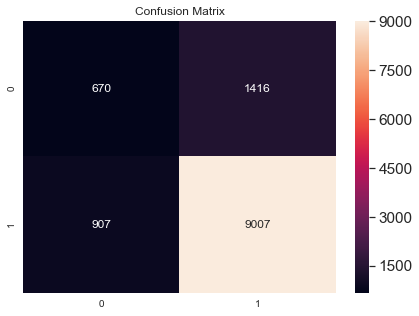

In [15]:
k_best=1
testing(Train_bow,train_y,test_bow,test_y,k_best)

#  Observations:





- Using Accuracy:



- First I performed Accuracy as metric the I got 83.86% Accuracy ,the best K value is 9 for both Brute and kd-tree methods
- For unseen data we got accuracy 83.81% , precision and recall also same as accuracy .



- Using Roc_Auc Score: 



- Then  I have taken other metric which is roc_auc Score , for BoW we got 54.23% ,the best K value is 1(may be if data is     high then our model predicts very well).
- For unseen data(Test data) we got roc_auc_Score 60% and precision and recall is 80.14%
- based on confusion matrix we can say that this model more biased towards positive values.

# TF--IDF Vectorization

In [16]:
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(train_x)
train_tfidf=tf_idf_vect.transform(train_x)
cv_tfidf= tf_idf_vect.transform(cv_x)
test_tfidf=tf_idf_vect.transform(test_x)
#Normalizing the data
train_tfidf=preprocessing.normalize(train_tfidf)
print("Train Data Size: ",train_tfidf.shape)
cv_tfidf= preprocessing.normalize(cv_tfidf)
print("CV Data Size: ",cv_tfidf.shape)
test_tfidf=preprocessing.normalize(test_tfidf)
print("Test Data Size: ",test_tfidf.shape)

Train Data Size:  (42000, 25241)
CV Data Size:  (5999, 25241)
Test Data Size:  (12000, 25241)


In [17]:
features=tf_idf_vect.get_feature_names()
len(features)

25241

In [18]:
#save tf idf vectors in files for future purpose
from scipy import sparse
sparse.save_npz("train_tfidf.npz",train_tfidf)
sparse.save_npz("cv_tfidf.npz",cv_tfidf)
sparse.save_npz("test_tfidf.npz",test_tfidf)
#your_matrix_back = sparse.load_npz("yourmatrix.npz")#to load our sparse matrix from npz files


The 'K' value 1 with highest roc_auc Score is 53.66474421629622


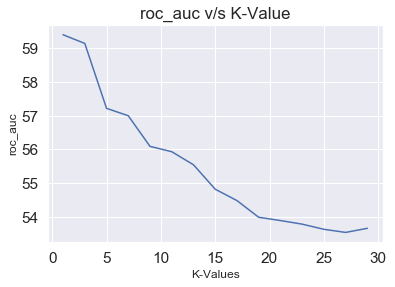

In [19]:
KNN_brute(train_tfidf,cv_tfidf,train_y,cvy)#applying model


The 'K' value 1 with highest roc_auc Score is 53.66474421629622


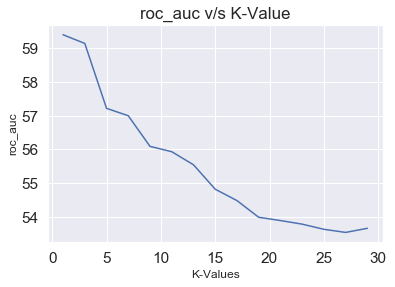

In [20]:
KNN_KD_Tree(train_tfidf,train_y,cv_tfidf,cvy)#applying model


ROC_AUC Score on test data:54.998%

Precision measure is  83.39166666666667

Recall measure is  83.39166666666667

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



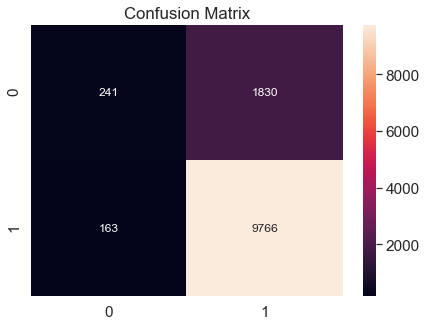

In [31]:
k_best=3
testing(train_tfidf,train_y,test_tfidf,test_y,k_best)#testing

# Observations:



- Using Accuracy:



- First I performed Accuracy as metric the I got 83.81% Accuracy ,the best value is 9 for both Brute and kd-tree methods
- for test data we got accuracy 84.133% and precision and recall also almost same as accuracy


- Using Roc_Auc Score:




- Then I have taken another metric which is ROC_AUC Score 53.93% ,Best K value is 1 for both Brute and kd-tree methods
- for test data we got Roc_Auc Score is 59.789% and precision and recall is 79.43 
- Here we can observe that Confusion matrix is showing that model is more biased towards positive reviews

# Avg Word2Vec

In [21]:
w2v_data=train #train data to build our own word2vec model

In [22]:
splitted_data = [] #splitting list whole 60K points to build word2v model
i=0
for row in data['CleanedText'].values:
    splitted_data.append(str(row).split())

In [23]:
splitted = []
i=0
for row in w2v_data['CleanedText'].values:
    splitted.append(str(row).split())

In [24]:
w2v_cv=cv
splitcv=[]
i=0
for row in w2v_cv['CleanedText'] .values:
    splitcv.append(str(row).split())

In [25]:
w2v_test=test
splittest=[]
i=0
for row in w2v_test['CleanedText'] .values:
    splittest.append(str(row).split())

In [26]:
from gensim.models import Word2Vec
data_w2v = Word2Vec(splitted,min_count=4,size=50, workers=4) #building word2vec model using splitted_data list

In [27]:
words =(data_w2v.wv.vocab)

In [28]:
len(words)

12043

In [29]:
from tqdm import tqdm
train_w2vec = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(splitted): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = data_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2vec.append(sent_vec)

100%|██████████| 42000/42000 [00:05<00:00, 7702.47it/s]


In [30]:
from tqdm import tqdm
cv_w2vec = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(splitcv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = data_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_w2vec.append(sent_vec)

100%|██████████| 5999/5999 [00:00<00:00, 7403.99it/s]


In [31]:
test_w2vec = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(splittest): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in words:
            vec = data_w2v.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2vec.append(sent_vec)

100%|██████████| 12000/12000 [00:01<00:00, 7959.05it/s]


In [32]:
train_w2v=preprocessing.normalize(train_w2vec)
cv_w2v=preprocessing.normalize(cv_w2vec)
test_w2v=preprocessing.normalize(test_w2vec)


The 'K' value 3 with highest roc_auc Score is 61.11185035536676


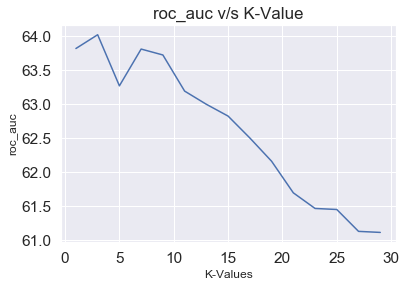

In [33]:
KNN_brute(train_w2v,cv_w2v,train_y,cvy)


The 'K' value 3 with highest roc_auc Score is 61.11185035536676


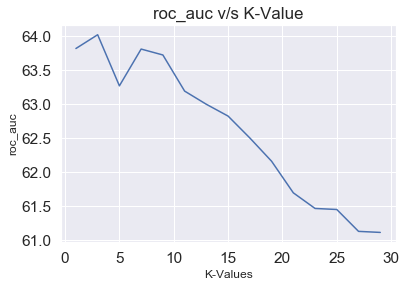

In [34]:
KNN_KD_Tree(train_w2v,train_y,cv_w2v,cvy)


ROC_AUC Score on test data:65.820%

Precision measure is  84.33333333333334

Recall measure is  84.33333333333334

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



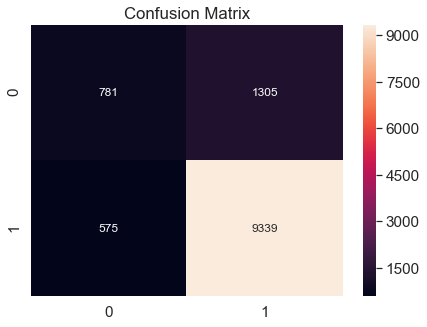

In [35]:
k_best=3
testing(train_w2v,train_y,test_w2v,test_y,k_best)

In [36]:
import pickle 
with open('train_w2v.pkl', 'wb') as tr:
    pickle.dump(train_w2v, tr)#loading our train w2v into pickle file
with open('cv_w2v.pkl', 'wb') as cvl:
    pickle.dump(cv_w2v, cvl)
with open('test_w2v.pkl', 'wb') as tst:
    pickle.dump(test_w2v, tst)
#with open('train_w2v.pkl', 'rb') as f:
 #   train_w2v = pickle.load(f)    #loading pickle file into list

# Observations:

 
 
 
 - Using Accuracy as Metric:
 
 
 
 - Here we can observe that both brute and kd tree gives same accuracy which is 85.61 % for K value is 9
 - For test data we got 85.40% accuracy 
 
 
 
 
 - Using Roc_Auc_Score:
 
 
 - we have taken another metric which is roc_auc curve it gives 61.63% score for both kd-tree and brute methods and here best K-Value is 1
 - on Unseen Data(Test Data) it given 65.03% Score
 - Precision and Recall is 81.65%
 - here also we can see confusion matrix tells us model is biased to positive points.

# tf-idf weighted Word2vec

In [37]:
from scipy.sparse import coo_matrix, vstack
final_tf_idf = vstack([train_tfidf,cv_tfidf,test_tfidf])
final_tf_idf.shape

(59999, 25241)

In [38]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidfw2v_train_vectors = [];
row=0;
for sent in splitted: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            
            vec =data_w2v.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += vec * tfidf
            weight_sum += tfidf
            
        except:
            pass
    sent_vec /= weight_sum
    tfidfw2v_train_vectors.append(sent_vec)
    row += 1
    #pdb.set_trace()

In [39]:
tfidf_w2v_train=preprocessing.normalize(tfidfw2v_train_vectors)#normalizing

In [40]:
import pdb
tfidf_feat = tf_idf_vect.get_feature_names()
tfidfw2v_cv_vectors = [];
row=0;
for sent in splitcv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            
            vec =data_w2v.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += vec * tfidf
            weight_sum += tfidf
            
        except:
            pass
    sent_vec /= weight_sum
    tfidfw2v_cv_vectors.append(sent_vec)
    row += 1
    #pdb.set_trace()

In [41]:
tfidfw2v_cv_vectors=np.nan_to_num(tfidfw2v_cv_vectors)#making nan vaules as zero's

In [42]:
tfidf_w2v_cv=preprocessing.normalize(tfidfw2v_cv_vectors)

In [43]:
tfidf_feat = tf_idf_vect.get_feature_names()
tfidfw2v_test_vectors = [];
row=0;
for sent in splittest: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            
            vec =data_w2v.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += vec * tfidf
            weight_sum += tfidf
            
        except:
            pass
    sent_vec /= weight_sum
    tfidfw2v_test_vectors.append(sent_vec)
    row += 1
    #pdb.set_trace()

In [44]:
tfidfw2v_test_vectors=np.nan_to_num(tfidfw2v_test_vectors)

In [45]:
tfidf_w2v_test=preprocessing.normalize(tfidfw2v_test_vectors)

In [46]:
import pickle 
with open('train_tfidf_w2v.pkl', 'wb') as t:
    pickle.dump(tfidf_w2v_train, t)#loading our train data tf idf weighted w2v into pickle file
with open('cv_tfidf_w2v.pkl', 'wb') as c:
    pickle.dump(tfidf_w2v_cv, c)#loading our cv data tf idf weighted w2v into pickle file
with open('test_tfidf_w2v.pkl', 'wb') as ts:
    pickle.dump(tfidf_w2v_test, ts)#loading our test data tf idf weighted w2v into pickle file


The 'K' value 1 with highest roc_auc Score is 0.5169874280716377


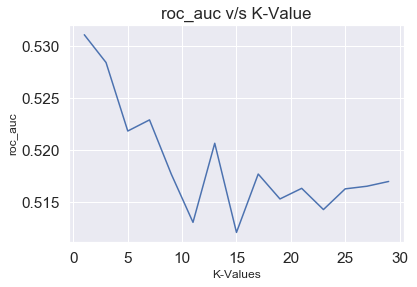

In [51]:
KNN_brute(tfidf_w2v_train,tfidf_w2v_cv,train_y,cvy)


The 'K' value 1 with highest roc_auc Score is 51.69874280716377


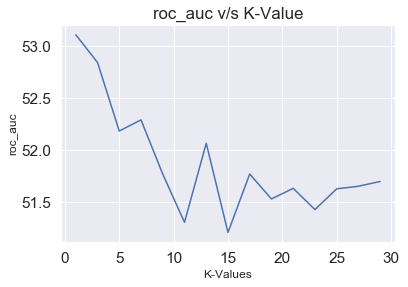

In [48]:
KNN_KD_Tree(tfidf_w2v_train,train_y,tfidf_w2v_cv,cvy)


ROC_AUC Score on test data:52.430%

Precision measure is  74.84166666666667

Recall measure is  74.84166666666667

Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



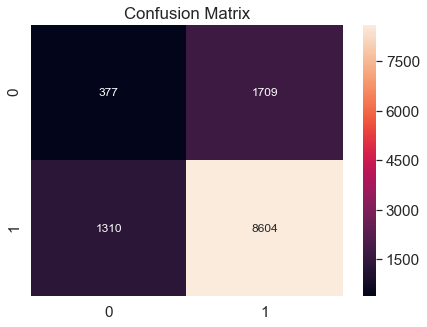

In [49]:
k_best=1
testing(tfidf_w2v_train,train_y,tfidf_w2v_test,test_y,k_best)

# Observations:



- Using Accuracy As a Metric:


- Here we can observe that both kd-tree and brute force methods given same accuracy 81.14% , best K value is 19.
- For unseen data(Test data) we got 81.476% accuracy which tells us model performing very bad.



- Using Roc_Auc_Score as Metric:


- we can also see Auc_Roc_Score as 52.00% for both kd-tree and brute methods s,Best K value is 1.
- For unseen data(Test Data) we got accuracy 53.455% which is slightly improved results.
- Precision and Recall is 75%
- Confusion matrix tells us model is more biased towards positive points.

In [113]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper parameter(K)","Roc_Auc Score","Test Roc_Auc"]

x.add_row(["BoW","Brute & kd-Tree",1,54.23,60.81])
x.add_row(["Tf-Idf","Brute & kd-Tree", 1,53.93,59.78])
x.add_row(["Avg Word2Vec","Brute & kd-tree",1,61.63,65.03])
x.add_row(["tf idf-Word2vec","Brute & kd-tree",1,52.01,53.45])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('**Conclusion:**')
print(x)

**Conclusion:**

+-----------------+-----------------+--------------------+---------------+--------------+
|    Vectorizer   |      Model      | Hyper parameter(K) | Roc_Auc Score | Test Roc_Auc |
+-----------------+-----------------+--------------------+---------------+--------------+
|       BoW       | Brute & kd-Tree |         1          |     54.23     |    60.81     |
|      Tf-Idf     | Brute & kd-Tree |         1          |     53.93     |    59.78     |
|   Avg Word2Vec  | Brute & kd-tree |         1          |     61.63     |    65.03     |
| tf idf-Word2vec | Brute & kd-tree |         1          |     52.01     |    53.45     |
+-----------------+-----------------+--------------------+---------------+--------------+


- Note:


- Here we taken taken 60K data points
- From all vectorizers ,BoW and Avg Word2Vec are works reasonably well with good results.
- It might produce good results if we take more data.